This notebook is for the newmark lab.

In [1]:
import imagej
import numpy as np
import imagej.convert as convert
from skimage.filters import threshold_otsu as otsu
from matplotlib import pyplot as plt
from imagej._java import jc
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from cellpose import models

# initialize ImageJ
ij = imagej.init(mode='interactive')
print(f"ImageJ2 version: {ij.getVersion()}")

2023-10-20 10:29:21.320066: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 10:29:21.322218: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 10:29:21.367859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 10:29:21.368928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 10:29:22.217405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

ImageJ2 version: 2.14.0/1.54f


Setup some helper functions.

In [2]:
def run_cellpose(image: np.ndarray) -> np.ndarray:
    """Run 2D cellpose on an input image
    """
    # run Cellpose on cytoplasm (grayscale)
    model = models.CellposeModel(gpu=False, model_type='cyto')
    ch = [0, 0]
    cyto_labels = model.eval(image, channels=ch, diameter=72.1)

    return cyto_labels[0]

def run_stardist(image: np.ndarray) -> np.ndarray:
    """Run 2D StarDist on an input image.
    """
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    nuc_labels, _ = model.predict_instances(normalize(image))

    return nuc_labels

def high_pass_fft(narr: np.ndarray, radius: int) -> np.ndarray:
    """
    Filter with a high-pass filter.
    Allows edges, details and noise to pass through while attenuating the low-
    frequency components (e.g. smooth variations and background)
    """
    # compute FFT on input image
    fft_narr = np.fft.fftn(narr)
    fft_shift_narr = np.fft.fftshift(fft_narr)

    # create circular high pass filter mask
    rows, cols = narr.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), dtype=np.uint8)

    # set the center of the mask to zero (block the DC component)
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 0

    # perform high pass filter
    shift_high_pass_result = fft_shift_narr * mask

    # shift the zero-frequency components back to the corners
    high_pass_result = np.fft.ifftshift(shift_high_pass_result)

    # reconstruct the filtered image from the array
    recon_narr = np.fft.ifftn(high_pass_result)

    return np.real(recon_narr)

Load the data and convert from Java to python (xarray).

In [3]:
data = ij.io().open("/home/edward/Documents/workspaces/coba/dbps/newmark/data/20230320_6_sm_Spol_aadc_klf4(633)_piwi1(G)_telo(R)_tes_63x_test.tif")
xdata = ij.py.to_xarray(data)
print(f"[INFO] Img Dimensions: {data.dims}")
print(f"[INFO] Img shape: {data.shape}")
print("**********")
print(f"[INFO] DataArray Dimensions: {xdata.dims}")
print(f"[INFO] DataArray Shape: {xdata.shape}")

[INFO] Img Dimensions: ('X', 'Y', 'Channel', 'Z')
[INFO] Img shape: (1024, 1024, 4, 29)
**********
[INFO] DataArray Dimensions: ('pln', 'row', 'col', 'ch')
[INFO] DataArray Shape: (29, 1024, 1024, 4)


View all 4 channels in a 1 x 4 grid with matplotlib.

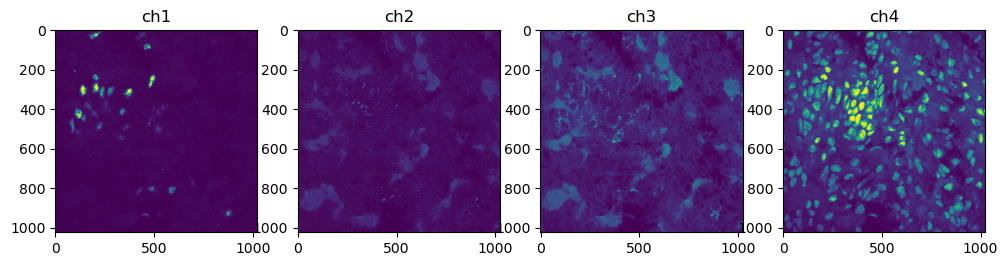

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(12, 9))
ax[0].imshow(xdata[10, :, :, 0])
ax[0].set_title("ch1")
ax[1].imshow(xdata[10, :, :, 1])
ax[1].set_title("ch2")
ax[2].imshow(xdata[10, :, :, 2])
ax[2].set_title("ch3")
ax[3].imshow(xdata[10, :, :, 3])
ax[3].set_title("ch4")

# display the image grid
plt.show()

# segment puncta

This section will segment the puncta.

This section uses imagej-ops to do the FFT transformation, so we need the java object.

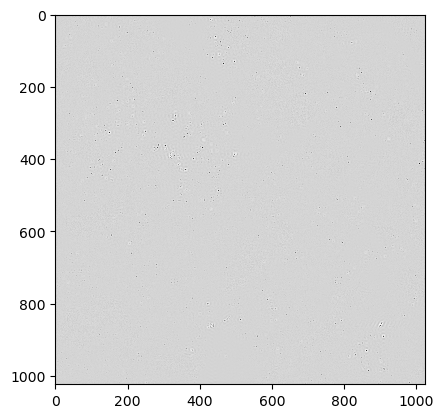

In [5]:
# slice the puncta channel from xdata and process with FFT
puncta = xdata[:, :, :, 1]
fft_results = []
for i in range(puncta.shape[0]):
    fft_results.append(high_pass_fft(puncta[i, :, :], radius=100))

fft_stack = np.stack(fft_results, axis=0)
xfft_stack = ij.py.to_xarray(fft_stack, dim_order=['pln', 'row', 'col']) # TODO: Bug if you just do ij.py.to_dataset(fft_stack)

# display a slice of the fft stack
ij.py.show(fft_stack[10, : ,:], cmap="Greys")

Otsu threshold the puncta.

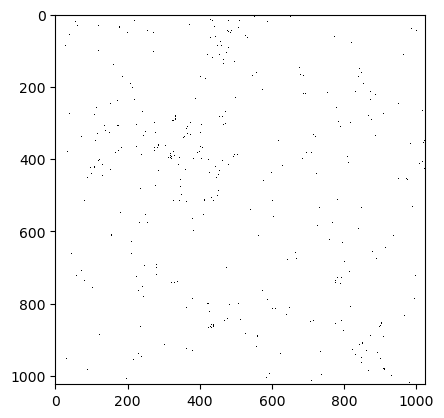

In [6]:
fft_thres = otsu(fft_stack)
fft_mask = fft_stack > fft_thres
xfft_mask = ij.py.to_xarray(fft_mask, dim_order=['pln', 'row', 'col'])

# display a slice of the fft mask
ij.py.show(fft_mask[10, :, :], cmap='Greys')

Show input, fft and mask side by side.

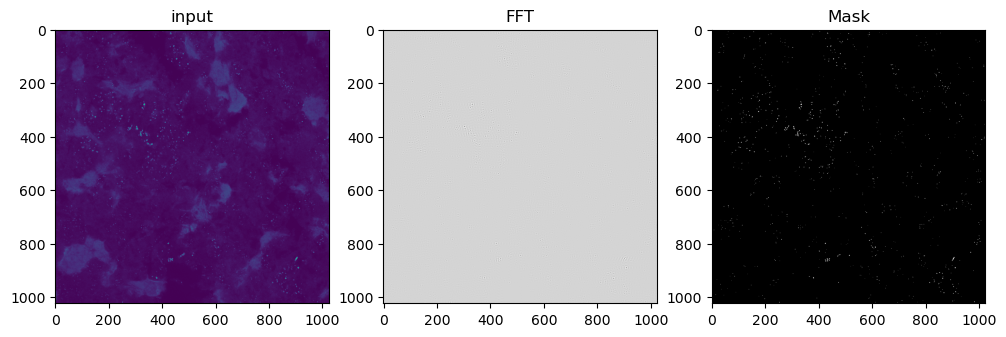

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 9))
ax[0].imshow(puncta[10, :, :])
ax[0].set_title('input')
ax[1].imshow(fft_stack[10, :, :], cmap="Greys")
ax[1].set_title('FFT')
ax[2].imshow(fft_mask[10, :, :], cmap="Greys_r")
ax[2].set_title('Mask')

plt.show()

Show the mask stack.

In [8]:
ij.ui().show(ij.py.to_dataset(xfft_mask))

Run connected component analysis (CCA) in 3D on the mask.

In [9]:
StructuringElement = imagej.sj.jimport('net.imglib2.algorithm.labeling.ConnectedComponents.StructuringElement')

fft_mask_ds = ij.py.to_dataset(xfft_mask)
labeing = ij.op().labeling().cca(fft_mask_ds, StructuringElement.EIGHT_CONNECTED)

Show the index image.

In [10]:
ij.ui().show(labeing.getIndexImg())

# StarDist

This section detectes nuclei via stardist

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


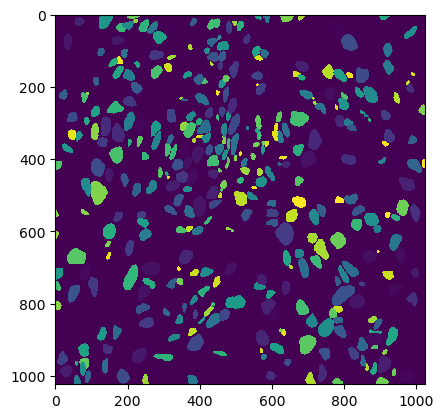

In [11]:
nuc_labels = run_stardist(ij.py.from_java(data[:, :, -1, 11]))
ij.py.show(nuc_labels)